In [312]:
import pandas as pd
import numpy as np
import requests
import math
import time
import json
from collections import Counter

import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt

from summa import keywords

import ast

from nltk import TreebankWordTokenizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import string

import scispacy
import spacy

from langdetect import detect

tokenizer = TreebankWordTokenizer()
stop_words_en = stopwords.words('english')
stop_words_fr = stopwords.words('french')
lemmatizer = WordNetLemmatizer()

punct = string.punctuation
punct = punct.replace("-", "") # don't remove hyphens


# Task 0: data extraction

In [2]:
PER_PAGE=200
WAIT_SECS=0.15
WORKS_FILE_PATH = './data/works.json'

In [ ]:
def fetch_page(cursor):
    base_url='https://api.openalex.org/works'
    url = '{base_url}?filter=from_publication_date:2017-01-01,to_publication_date:2021-12-31,raw_affiliation_string.search:grenoble&cursor={cursor}&per-page={per_page}&mailto={mailto}'.format(
        base_url=base_url,
        cursor=cursor,
        per_page=PER_PAGE,
        mailto='bertagrim@gmail.com'
    )
    print('Senging GET {url}'.format(url=url))
          
    response = requests.get(url)
    
    if (response.status_code == 200):
        print('OK')
        return response.json()
    else:
        print('Request failed: {status_code}'.format(status_code=response.status_code))
        print(response.text)
    


In [3]:
def save_entries(page_n, results):
    offset = page_n * PER_PAGE
    from_entry_num = offset
    to_entry_num = from_entry_num + len(results)
    print('Saving new entries in positions: {from_entry_num}..{to_entry_num}'.format(
        from_entry_num=from_entry_num,
        to_entry_num=to_entry_num
    ))
    with open(WORKS_FILE_PATH, 'r+', encoding='utf-8') as file:
        entries = json.load(file)
        entries[from_entry_num:] = results
        file.seek(0)
        json.dump(entries, file)

In [5]:
page_1 = fetch_page('*')
num_pages = math.ceil(page_1['meta']['count']/PER_PAGE)
num_pages

In [ ]:
cursor='*'
works=[]
for page_n in range(0, num_pages):
    print("Fetching page {} ...".format(page_n))
    page = fetch_page(cursor)
    works.extend(page['results'])
#     save_entries(
#         page_n=page_n,
#         results=page['results']
#     )
    time.sleep(WAIT_SECS)
    cursor=page['meta']['next_cursor']
    
with open(WORKS_FILE_PATH, 'w', encoding='utf-8') as file:
        json.dump(works, file)


In [6]:
with open(WORKS_FILE_PATH) as f:
    data = json.load(f)

In [7]:
data_string = json.dumps(data)

In [18]:
df = pd.read_json(data_string)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49579 entries, 0 to 49578
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       49579 non-null  object 
 1   doi                      39389 non-null  object 
 2   title                    49572 non-null  object 
 3   display_name             49572 non-null  object 
 4   relevance_score          49579 non-null  float64
 5   publication_year         49579 non-null  int64  
 6   publication_date         49579 non-null  object 
 7   ids                      49579 non-null  object 
 8   host_venue               49579 non-null  object 
 9   type                     46346 non-null  object 
 10  open_access              49579 non-null  object 
 11  authorships              49579 non-null  object 
 12  cited_by_count           49579 non-null  int64  
 13  biblio                   49579 non-null  object 
 14  is_retracted          

Regarding cleaning, at this point I do a very minimal cleaning. First, I drop a number of columns that I know I will not need for any of them (I know this only after having completed the tasks). I do this simply to make computation costs lower. Some of these columns would be useful in a deeper analysis. I will go back to this in Task 7 and explain how I think we could use some of them to extend our study.

In [57]:
df_clean=df.drop(columns=['is_authors_truncated', 
                 'is_retracted', 
                 'related_works', 
                 'display_name',
                 'alternate_host_venues', 
                 'mesh', 
                 'updated_date', 
                 'created_date', 
                 'open_access',
                 'cited_by_api_url',
                 'counts_by_year',
                 'biblio',
                 'host_venue',
                 'ids',
                 'open_access',
                 'referenced_works',
                 'related_works',
                 'relevance_score',
                 'ngrams_url'])

### Columns I kept

- 'id': identifier by OpenAlex
- 'title': title of the work 
- 'doi'
- 'publication_year': publication year.
- 'publication_date': publication date.
- 'type': type of work (journal, book, etc)
- 'authorships': object containing information about the author/s of the work.
- 'cited_by_count': how many works cite it 
- 'is_paratext' :  paratext is stuff that's in scholarly venue (like a journal) but is about the venue rather than a scholarly work properly speaking. 
- 'concepts': the concepts that the work is about.
- 'abstract_inverted_index': the abstract, as an inverted index.

In [58]:
df_clean.type.value_counts()

journal-article        33454
proceedings-article     7377
posted-content          2126
book-chapter            1887
dissertation             623
other                    351
book                     278
report                   133
peer-review               54
dataset                   16
proceedings               15
monograph                 11
reference-entry            8
component                  5
journal-issue              4
report-series              2
reference-book             1
journal                    1
Name: type, dtype: int64

In [59]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49579 entries, 0 to 49578
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       49579 non-null  object 
 1   doi                      39389 non-null  object 
 2   title                    49572 non-null  object 
 3   publication_year         49579 non-null  int64  
 4   publication_date         49579 non-null  object 
 5   type                     46346 non-null  object 
 6   authorships              49579 non-null  object 
 7   cited_by_count           49579 non-null  int64  
 8   is_paratext              43962 non-null  float64
 9   concepts                 49579 non-null  object 
 10  abstract_inverted_index  40226 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.2+ MB


Another thing we will have to deal with too is nulls. However, since my strategy throughout the tasks will be to created a custom dataset for each task, I will deal with nulls as needed in each particular case. If I were to, say, drop all of them now, I would lose a lot of information that I would otherwise have for specific tasks (in particular, 'abstract_inverted_index' has a higer number of nulls, but I will not need abstracts for some of the tasks). 

Next, I use the column 'is_paratext' to filter out works that are not scholarly works. I also drop this column afterwards.

In [60]:
df_clean.is_paratext.value_counts()

0.0    43921
1.0       41
Name: is_paratext, dtype: int64

In [61]:
df_clean=df_clean[df_clean.is_paratext==0.0].reset_index(drop=True)

In [62]:
#sanity check
df_clean.is_paratext.value_counts()

0.0    43921
Name: is_paratext, dtype: int64

In [63]:
df_clean.drop(columns='is_paratext', inplace=True)

Finally, there is the issue of duplicates. 

In [65]:
df_clean.head()

,id,doi,title,publication_year,publication_date,type,authorships,cited_by_count,concepts,abstract_inverted_index
0,https://openalex.org/W2511949746,https://doi.org/10.1016/j.eururo.2016.08.003,EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...,2017,2017-04-01,journal-article,"[{'author_position': 'first', 'author': {'id':...",2240,"[{'id': 'https://openalex.org/C71924100', 'wik...","{'To': [0], 'present': [1, 392], 'a': [2, 49, ..."
1,https://openalex.org/W2805354595,https://doi.org/10.1056/nejmoa1716948,Atezolizumab for First-Line Treatment of Metas...,2018,2018-06-04,journal-article,"[{'author_position': 'first', 'author': {'id':...",2084,"[{'id': 'https://openalex.org/C2775949291', 'w...","{'The': [0, 84, 147, 183, 330], 'cancer-cell-k..."
2,https://openalex.org/W4205946977,https://doi.org/10.1111/1467-8330.00247,Neoliberalizing Space,2020,2020-06-22,journal-article,"[{'author_position': 'first', 'author': {'id':...",2513,"[{'id': 'https://openalex.org/C2778572836', 'w...",None
3,https://openalex.org/W2796277309,https://doi.org/10.3762/bjnano.9.98,Review on nanoparticles and nanostructured mat...,2018,2018-04-03,journal-article,"[{'author_position': 'first', 'author': {'id':...",1535,"[{'id': 'https://openalex.org/C171250308', 'wi...","{'Nanomaterials': [0], '(NMs)': [1], 'have': [..."
4,https://openalex.org/W2969802526,https://doi.org/10.1038/s41575-019-0186-y,A global view of hepatocellular carcinoma: tre...,2019,2019-08-22,journal-article,"[{'author_position': 'first', 'author': {'id':...",1592,"[{'id': 'https://openalex.org/C71924100', 'wik...","{'Hepatocellular': [0], 'carcinoma': [1], '(HC..."


Finally, I deal with duplicates in a rather naive way, since I will go back to the problem of duplicates in Task 6. For now, I simply check if there are works that have the same features (I cannot use unhashable features, so I have to drop some columns; moreover, I know that the id is unqieu so I drop it too).

In [68]:
df_clean.drop(columns=['concepts', 'authorships', 'abstract_inverted_index', 'id']).duplicated().sum()

961

There are 961 works that have the same doi, title, publication year and date, type and cited_by_count. I think we can be fairly certain that these are indeed duplicates. So I drop them. In a real scenario, I would address this issue in more detail. To begin with I would investigate more how the data was colelcted and what might give rise to duplicates. As I said, I will go back to this in Task 6, where I will investigate a different way to detect duplicates.

In [72]:
df_clean=df_clean.drop_duplicates(subset=df_clean.drop(columns=['concepts', 'authorships', 'abstract_inverted_index', 'id']).columns).reset_index(drop=True)

In [73]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42960 entries, 0 to 42959
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       42960 non-null  object
 1   doi                      39176 non-null  object
 2   title                    42953 non-null  object
 3   publication_year         42960 non-null  int64 
 4   publication_date         42960 non-null  object
 5   type                     42945 non-null  object
 6   authorships              42960 non-null  object
 7   cited_by_count           42960 non-null  int64 
 8   concepts                 42960 non-null  object
 9   abstract_inverted_index  35817 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.3+ MB


# Task 1: time trends and production indicators

First, I prepare the dataframe that I will need for this particular task.

In [85]:
df1=df_clean[['id', 'title', 'concepts', 'publication_year', 'publication_date']]

Let's see if we have to do any further cleaning. We check the nulls. There are very few. We just drop them.

In [86]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42960 entries, 0 to 42959
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                42960 non-null  object
 1   title             42953 non-null  object
 2   concepts          42960 non-null  object
 3   publication_year  42960 non-null  int64 
 4   publication_date  42960 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [87]:
df1_clean = df1.dropna().reset_index(drop=True)

In [88]:
df1_clean['publication_date']=pd.to_datetime(df1_clean['publication_date'])
df1_clean['month_year'] = pd.to_datetime(df1_clean['publication_date']).dt.to_period('M')
df1_clean['publication_month'] = pd.to_datetime(df1_clean['publication_date']).dt.month

We need to extract the concepts of level 0 to see to which general areas of research each work belongs.

In [92]:
def get_concepts_0(orig_list):
    pruned_list=[item['display_name'].lower().replace(' ', '-') for item in orig_list if item['level']==0]
    return pruned_list

df1_clean['concepts_level_0']=df1_clean['concepts'].apply(get_concepts_0)

In [93]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42953 entries, 0 to 42952
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 42953 non-null  object        
 1   title              42953 non-null  object        
 2   concepts           42953 non-null  object        
 3   publication_year   42953 non-null  int64         
 4   publication_date   42953 non-null  datetime64[ns]
 5   month_year         42953 non-null  period[M]     
 6   publication_month  42953 non-null  int64         
 7   concepts_level_0   42953 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4), period[M](1)
memory usage: 2.6+ MB


## Data analysis

In [94]:
df1_clean.publication_year.value_counts()

2021    8805
2017    8633
2018    8592
2020    8462
2019    8461
Name: publication_year, dtype: int64

<AxesSubplot: xlabel='publication_year', ylabel='count'>

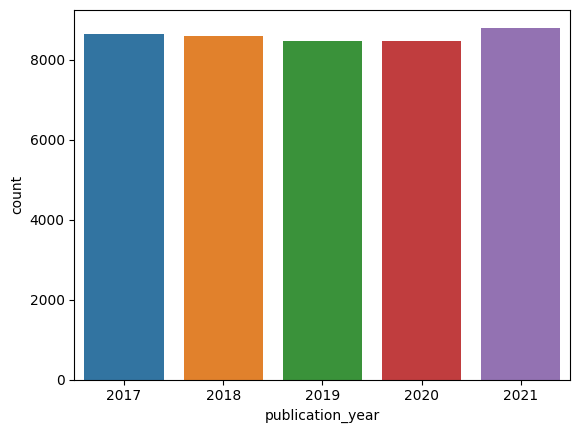

In [95]:
sns.countplot(data = df1_clean, x="publication_year")

The amount of publications with Grenoble authors per year is actually very stable. Interestingly, there is a constant decrease until 2021, where the number goes up. In a proper study, we would try to find out why that is the case. An initial hypothesis might be that it has to do with the COVID pandemic. As is well-known , the pandemic has given rise to a huge amount of publications in realtion with it. Could this be the exaplanation? We will be able to answer this question in a minute, when we analyze the count of works by year and area of research.

In [96]:
categories=[]
for item in df1_clean['concepts_level_0'].values:
    categories.extend(item)
unique=list(set(categories))
unique

['physics',
 'geography',
 'engineering',
 'chemistry',
 'materials-science',
 'art',
 'environmental-science',
 'philosophy',
 'history',
 'geology',
 'sociology',
 'economics',
 'mathematics',
 'political-science',
 'business',
 'biology',
 'computer-science',
 'psychology',
 'medicine']

In [98]:
s = df1_clean['concepts_level_0']
dummies = pd.get_dummies(s.apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
final = pd.concat([df1_clean, dummies], axis=1).drop(columns=['concepts', 'concepts_level_0'])

/var/folders/8t/pdc266556nvbq2phrrf21cd00000gn/T/ipykernel_3948/4120625108.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dummies = pd.get_dummies(s.apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
/var/folders/8t/pdc266556nvbq2phrrf21cd00000gn/T/ipykernel_3948/4120625108.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies = pd.get_dummies(s.apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)


In [99]:
grouped = final.groupby(['publication_year'])
grouped_months = final.groupby(['month_year'])

In [175]:
df_years=pd.DataFrame()
for value in unique:
    df_years[value]=grouped[value].sum()
df_years=df_years.reset_index()

In [177]:
df_months=pd.DataFrame()
for value in unique:
    df_months[value]=grouped_months[value].sum()
df_months=df_months.reset_index()

First, we look at a line plot with all the disciplines. It's not the clearest plot, that's why we used interactive annotations. If you hover over the different points, you can check its different attributes.

In [176]:
fig = px.line(df_years, markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=1000,
    height=700)

fig.update_yaxes(range=[-100, 3700])
fig.show()

In [201]:
#falta
diffs=df_years.T
diffs['diff_19_21'] = diffs.iloc[:, 4].sub(diffs.iloc[:,2], axis=0)
diffs['diff_20_21'] = diffs.iloc[:, 4].sub(diffs.iloc[:,3], axis=0)

diffs

,0,1,2,3,4,diff_19_21,diff_20_21
publication_year,2017.0,2018.0,2019.0,2020.0,2021.0,2.0,1.0
physics,3538.0,3493.0,3447.0,3436.0,3419.0,-28.0,-17.0
geography,402.0,461.0,472.0,472.0,582.0,110.0,110.0
engineering,1944.0,1882.0,1829.0,1725.0,1834.0,5.0,109.0
chemistry,2074.0,1937.0,2011.0,2166.0,2136.0,125.0,-30.0
materials-science,2718.0,2539.0,2462.0,2445.0,2302.0,-160.0,-143.0
art,286.0,325.0,307.0,306.0,281.0,-26.0,-25.0
environmental-science,428.0,460.0,500.0,471.0,549.0,49.0,78.0
philosophy,528.0,580.0,575.0,611.0,650.0,75.0,39.0
history,53.0,76.0,83.0,90.0,84.0,1.0,-6.0


In [212]:
diffs.drop('publication_year').sort_values(by=['diff_19_21'])

,0,1,2,3,4,diff_19_21,diff_20_21
materials-science,2718.0,2539.0,2462.0,2445.0,2302.0,-160.0,-143.0
computer-science,3016.0,3093.0,2940.0,2730.0,2898.0,-42.0,168.0
physics,3538.0,3493.0,3447.0,3436.0,3419.0,-28.0,-17.0
art,286.0,325.0,307.0,306.0,281.0,-26.0,-25.0
history,53.0,76.0,83.0,90.0,84.0,1.0,-6.0
engineering,1944.0,1882.0,1829.0,1725.0,1834.0,5.0,109.0
environmental-science,428.0,460.0,500.0,471.0,549.0,49.0,78.0
business,279.0,285.0,275.0,277.0,340.0,65.0,63.0
philosophy,528.0,580.0,575.0,611.0,650.0,75.0,39.0
political-science,452.0,513.0,516.0,446.0,594.0,78.0,148.0


An initial observation is that medicine and biology are the two disciplines that go up most significantly between 2019 and 2021, which could be explained by the covid-related publications. However they are by no means the only one. In fact, most diciplines go up in that period. This rise of publications pretty much accross the board could still be explained by covid: could it be that researchers were more productive throughout the pandemic period, due having less teaching duties/meetings/other in person events? This is something I would look into in a longer study. 

As follows, I plot the same information for separate groups of disciplines, to have a closer look inside each group.

In [155]:
social=['economics', 'sociology', 'political-science', 'business', 'geography']
science=['medicine', 'biology',  'psychology']
earth=['environmental-science', 'geology', 'materials-science']
engineering_maths=['engineering', 'computer-science', 'chemistry', 'physics', 'mathematics']
humanities=['philosophy', 'history', 'art']

df_social=df_years[social]
df_earth=df_years[earth]
df_science=df_years[science]
df_engineering=df_years[engineering_maths]
df_humanities=df_years[humanities]

In [158]:
fig = px.line(df_social, title="Social sciences", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

In [180]:
fig = px.line(df_earth, title="Earth sciences", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

In [161]:
fig = px.line(df_engineering, title="Engineering and maths", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

In [165]:
fig = px.line(df_science, title="Biological sciences", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

In [166]:
fig = px.line(df_humanities, title="Humanities", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

Observations: 

- Social sciences observe a significant rise from 2020 to 2021 across the board. At this point, I don't know why that is the case. I would need to gather more domain knowledge.
- Another relevant tendencyt that we already observed is that what I called "biological sciences" (for lack of a better term) also go up in all its subdisciplines from 2019 to 2021. I already suggested some possible causes of this, but a proper study would need to be undertaken to find out why.
- Finally, note that the only... 
#falta

Let's finish by taking a look at the monthly progress of publication counts.


In [181]:
y_cols=df_months.drop(columns='month_year').columns
y_cols

Index(['physics', 'geography', 'engineering', 'chemistry', 'materials-science',
       'art', 'environmental-science', 'philosophy', 'history', 'geology',
       'sociology', 'economics', 'mathematics', 'political-science',
       'business', 'biology', 'computer-science', 'psychology', 'medicine'],
      dtype='object')

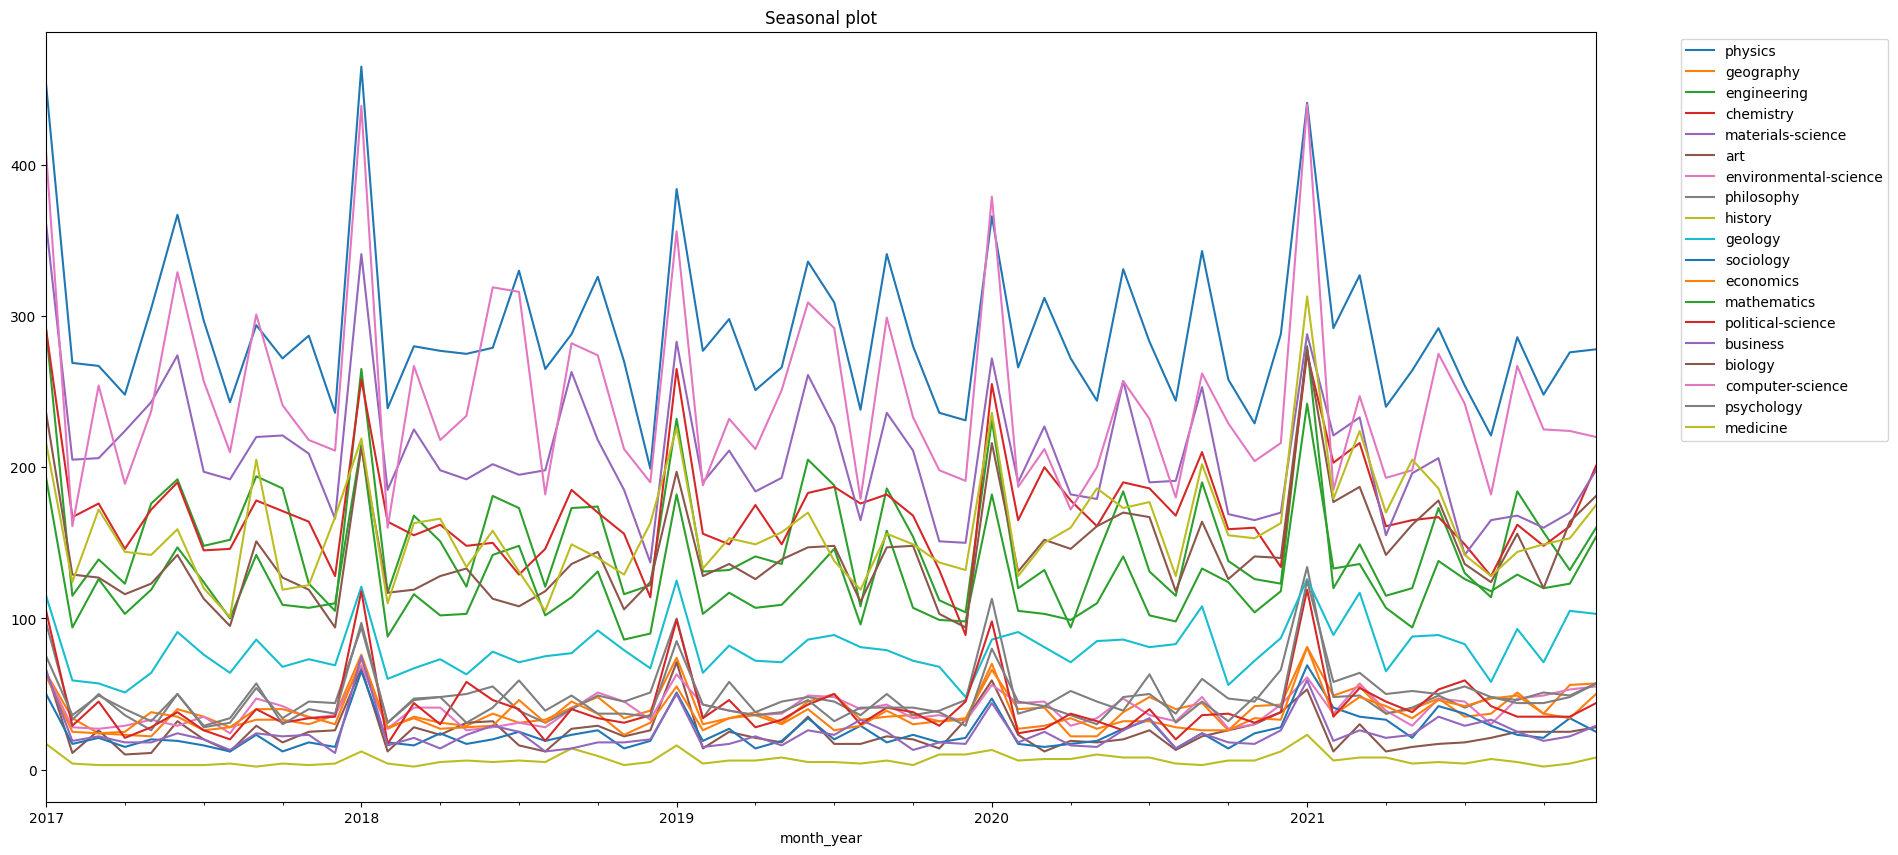

In [193]:
pd.options.plotting.backend = 'matplotlib'

df_months.plot(x='month_year', 
             y=y_cols, 
             title='hello');
plt.rcParams["figure.figsize"] = (20,10)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# add title
plt.title('Seasonal plot')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);


We observe seasonality straightaway. Let us plot the monthly progressions in more detail by confirming tthe trend we already observe in this plot.

In [194]:
d1 = {}
for x in unique:
    d1["{}".format(x)] = final[[x, "publication_year", "publication_month"]][final[x]==1]

In [195]:
d2={}
for key, value in d1.items():
    d2["grouped_{}".format(key)] = value.groupby(['publication_year','publication_month']).count()

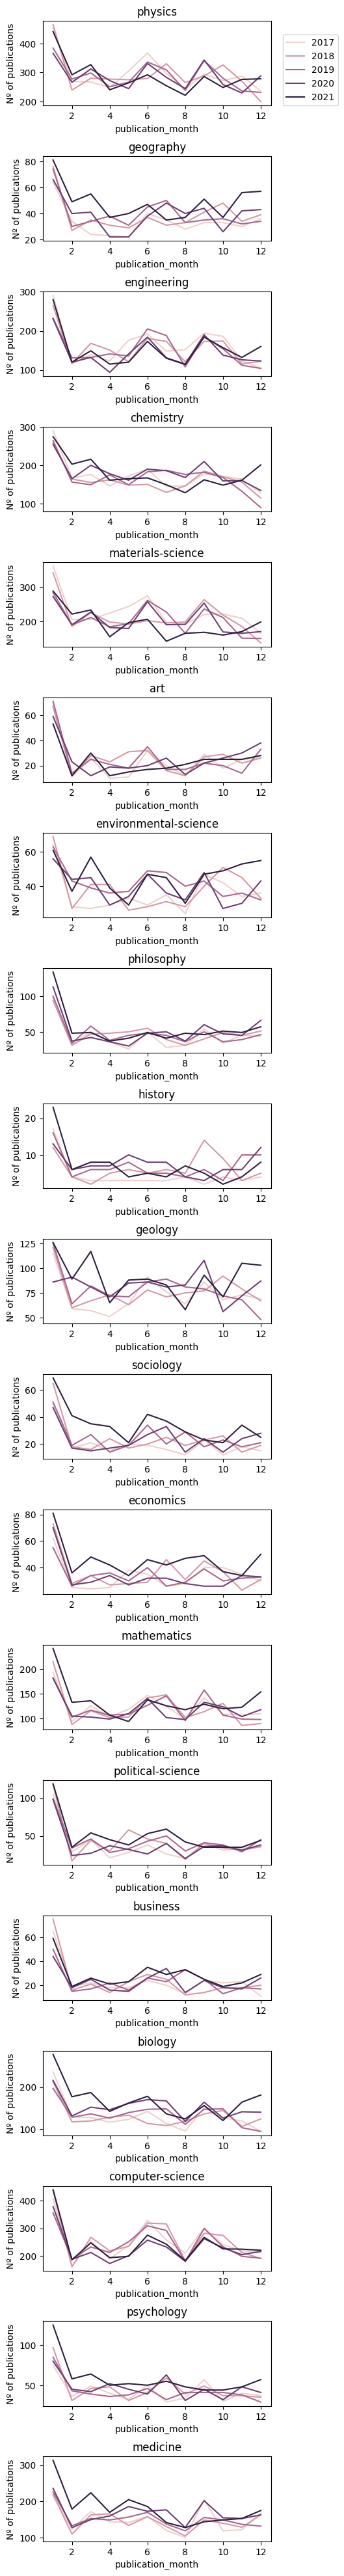

In [196]:
fig, axes = plt.subplots(19, 1, figsize=(5, 40))
fig.tight_layout(pad=3.5)
 
for k, key in enumerate(d2):
    if k==0:
        ax=sns.lineplot(ax=axes[k],
             data=d2[key], 
             x='publication_month', 
             y=key.split('_')[1], 
             hue='publication_year',
            legend=True)
        ax.set(ylabel='Nº of publications')
        ax.set(title=key.split('_')[1])
        ax.legend(loc=(1.05, 0))
    else:
        ax=sns.lineplot(ax=axes[k],
             data=d2[key], 
             x='publication_month', 
             y=key.split('_')[1], 
             hue='publication_year',
            legend=False)
        ax.set(title=key.split('_')[1])
        ax.set(ylabel='Nº of publications')

The seasonal trend gets confirmed in these plots: the beginning of the year sees a much higher number of publications. Moreover, there seems to be a rise around June and around September for most disciplines too.

# Task 2: collaboration network

For this task I will define 3 notions of connectedness, understood as measuring how connected a given author is to other Grenoble authors. Since this is a vague notion, it can be made precise in various ways. The notions I use are:

- *Connectedness 1*: How many publications with other Grenoble-based authors the author has. This count gives a higher weight to those authors that are prolific, even if they haven't collaborated with too many different people.
 - Connectedness 2: With how many different Grenoble-based authors the author has published. This other notion focuses on the number of people the author has collaborated with and sets aside whether the author has published a lot or not.
- *Connectedness 3*: A multiplication of both previous notions, givin us a combined factor.

In a longer study, I would have liked to explore other notions of connectedness. A couple of ideas:
 - A factor of the first two together with the average impact factor (in some of its forms) of the relevant publications, to see if as well as connected, the collaborations are having impactful outcomes.
 - A recursive notion of connectedness where an author is more connected the more connections they have with more connected authors.
 
But for the purposes of this exercise, let's have a look at the first three.

In [219]:
df2 = df_clean[['id', 'authorships',]]
df2.info()
#there are no nulls. No further cleaning required.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42960 entries, 0 to 42959
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           42960 non-null  object
 1   authorships  42960 non-null  object
dtypes: object(2)
memory usage: 671.4+ KB


In [217]:
def num_grenoble_authors(row):
    num=len([author for author in row['authorships'] if (author['raw_affiliation_string'] is not None) and ("grenoble" in author['raw_affiliation_string'].lower())])
    if num>1:
        return 1
    else:
        return 0

In [220]:
df2['is_work_connected'] = df2.apply(num_grenoble_authors, axis=1)

/var/folders/8t/pdc266556nvbq2phrrf21cd00000gn/T/ipykernel_3948/81781065.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [222]:
df2.is_work_connected.value_counts()

1    21879
0    21081
Name: is_work_connected, dtype: int64

In [223]:
def extract_author_ids(row):
    authors = [author['author']['id'] for author in row['authorships']]
    return authors

df2['authors'] = df2.apply(lambda row: extract_author_ids(row), axis=1) 

/var/folders/8t/pdc266556nvbq2phrrf21cd00000gn/T/ipykernel_3948/316629148.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [224]:
flat_list = [item for items in df2.authorships.values for item in items if (item['raw_affiliation_string'] is not None) and ('grenoble' in item['raw_affiliation_string'].lower())]

authors_sim = [{'author_id': item['author']['id'],
              'name':item['author']['display_name']}
               for item in flat_list]

In [226]:
grenoble_authors = pd.DataFrame.from_dict(authors_sim)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106099 entries, 0 to 106098
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   author_id  106099 non-null  object
 1   name       106099 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [227]:
grenoble_authors.duplicated().sum()

75168

In [228]:
grenoble_authors = grenoble_authors.drop_duplicates(ignore_index=True)

In [229]:
grenoble_authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30931 entries, 0 to 30930
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author_id  30931 non-null  object
 1   name       30931 non-null  object
dtypes: object(2)
memory usage: 483.4+ KB


In [234]:
work_author_pairs = df2[df2['is_work_connected']==1][['id', 'authors']]

In [235]:
work_author_pairs = work_author_pairs.explode('authors')

In [236]:
grenoble_work_author_pairs = work_author_pairs[work_author_pairs['authors'].isin(grenoble_authors['author_id'])]

In [237]:
count_works = grenoble_work_author_pairs.groupby('authors').count().reset_index()
count_works

,authors,id
0,https://openalex.org/A1002805135,2
1,https://openalex.org/A1007915466,6
2,https://openalex.org/A100908830,1
3,https://openalex.org/A1009761877,4
4,https://openalex.org/A1015310080,1
...,...,...
26082,https://openalex.org/A974871389,15
26083,https://openalex.org/A975039927,1
26084,https://openalex.org/A97906723,6
26085,https://openalex.org/A985776687,4


### Connectedness 1

In [238]:
def get_connectedness1(row):
    author_id = row['author_id']
    if not count_works['id'][count_works['authors']==author_id].empty:
        count = count_works['id'][count_works['authors']==author_id].values[0]
        return count
    else:
        return 0

In [239]:
grenoble_authors['connectedness_1']=grenoble_authors.apply(get_connectedness1, axis=1)

In [240]:
grenoble_authors.to_csv('data/grenoble_authors1.csv', index=False)

Something I observed is that there is duplication of names, with different ids. Since personal names are quite easy to be actually duplicated in real life, I did not delete them. I only removed duplicates in both the id and the name. In a proper study, I would get more information about the authors (perhaps downloading author information from the same API would be enough) and try to find out if these are really duplicates or not.

In [241]:
grenoble_authors[grenoble_authors.name=="Jean-Louis Pépin"]

,author_id,name,connectedness_1
8,https://openalex.org/A2596381244,Jean-Louis Pépin,205
13158,https://openalex.org/A4227283002,Jean-Louis Pépin,1
19310,https://openalex.org/A4202217154,Jean-Louis Pépin,1
27866,https://openalex.org/A4260292885,Jean-Louis Pépin,1
29688,https://openalex.org/A4261509675,Jean-Louis Pépin,1


### Connectedness 2

In [243]:
def get_connectedness2(row):
    author_id = row['author_id']
    works = grenoble_work_author_pairs['id'][grenoble_work_author_pairs['authors']==author_id]
    num_colabs = len(np.unique((grenoble_work_author_pairs['authors'][(grenoble_work_author_pairs['authors']!=author_id) & grenoble_work_author_pairs['id'].isin(list(works))]).values))
    return num_colabs

In [244]:
grenoble_authors['connectedness_2']=grenoble_authors.apply(get_connectedness2, axis=1)

In [245]:
grenoble_authors.to_csv('data/grenoble_authors2.csv', index=False)

In [246]:
grenoble_authors = pd.read_csv('data/grenoble_authors.csv')  

In [248]:
grenoble_authors.head()

,author_id,name,connectedness_1,connectedness_2
0,https://openalex.org/A2081927895,Michel Bolla,1,8
1,https://openalex.org/A2967507403,Christian A. Thomas,0,0
2,https://openalex.org/A4208415029,Frédéric Bally,0,0
3,https://openalex.org/A2050409607,Alain Dufresne,38,36
4,https://openalex.org/A2061986354,Pierre Hainaut,23,103


### Connectedness 3

In [249]:
grenoble_authors['connectedness_3'] = grenoble_authors['connectedness_1'] * grenoble_authors['connectedness_2']

In [250]:
grenoble_authors.nlargest(10, 'connectedness_3')

,author_id,name,connectedness_1,connectedness_2,connectedness_3
8,https://openalex.org/A2596381244,Jean-Louis Pépin,206,220,45320
2037,https://openalex.org/A2196954048,Gerard Ghibaudo,148,249,36852
173,https://openalex.org/A2420782966,Renaud Tamisier,180,179,32220
1397,https://openalex.org/A1975902673,Jean-François Timsit,130,207,26910
613,https://openalex.org/A2308027254,J.M. Hartmann,101,248,25048
205,https://openalex.org/A1955230402,Yohann Couté,97,244,23668
1430,https://openalex.org/A2974844775,Maud Vinet,88,231,20328
1851,https://openalex.org/A2171459722,Laurence Bouillet,94,203,19082
1429,https://openalex.org/A1916288200,Sylvain Barraud,92,177,16284
1175,https://openalex.org/A2577985073,Jean-Luc Bosson,60,255,15300


By sorting the data by the third notion of connectedness we get a tope 10 of the most connected authors. Let's take a quick look at the structure of the data.

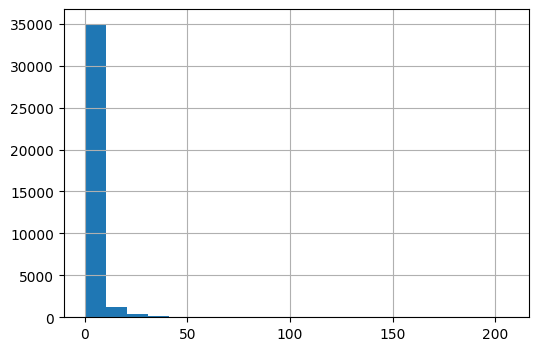

In [260]:
plt.figure(figsize=(6,4))
hist = grenoble_authors['connectedness_1'].hist(bins=20)

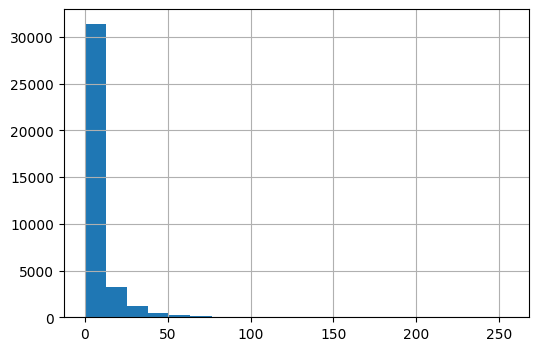

In [259]:
plt.figure(figsize=(6,4))
hist = grenoble_authors['connectedness_2'].hist(bins=20)

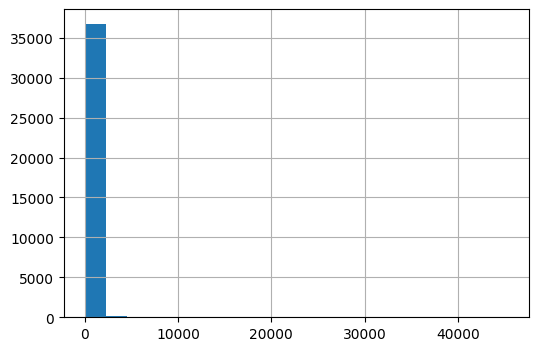

In [257]:
plt.figure(figsize=(6,4))
hist = grenoble_authors['connectedness_3'].hist(bins=20)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ffa8cff5a20>,
 'caps': [<matplotlib.lines.Line2D at 0x7ffa8cff5f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ffa8cff5810>],
 'medians': [<matplotlib.lines.Line2D at 0x7ffa8cff64a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ffa8cff6740>],
 'means': []}

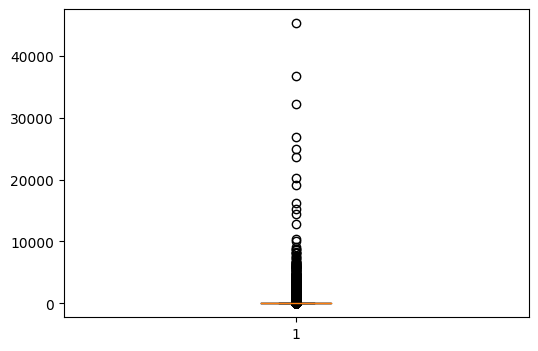

In [258]:
plt.figure(figsize=(6,4))
plt.boxplot(grenoble_authors['connectedness_3'])

The data is extremely skewed. What this tells us is that there are very few authors that are much more connected than the rest. Most of the Grenoble-based authors are not very connected at all. This means that the network of collaboration we are looking at is one where there are a few very central nodes and an extremely large amount of nodes that are in the outskirts of the graph. In other words, the collaboration is not at all well distributed across the population. A few people manage to collaborate with a lot of other people and publish a lot, but most people don't. This is something we would have to focus on when trying to improve the interconnectivity of the Grenoble academic world, since, presumably, what we are interested in is having a situation where most people are connected with other Grenoble-based researchers. So this would be one of the insights I would offer to the stakeholders in this case.

# Task 3: keywords

In [263]:
df3 = df_clean[['id', 'title', 'abstract_inverted_index']]

In [264]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42960 entries, 0 to 42959
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       42960 non-null  object
 1   title                    42953 non-null  object
 2   abstract_inverted_index  35817 non-null  object
dtypes: object(3)
memory usage: 1007.0+ KB


We are missing quite a few abstracts, so we drop those datapoints.

In [265]:
df3 = df3.dropna().reset_index(drop=True)

Moreover, some indexs are actually empty dictionaries. We drop those too.

In [266]:
df3 = df3[df3['abstract_inverted_index']!={}].reset_index(drop=True)

In [267]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35802 entries, 0 to 35801
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       35802 non-null  object
 1   title                    35802 non-null  object
 2   abstract_inverted_index  35802 non-null  object
dtypes: object(3)
memory usage: 839.2+ KB


In [ ]:
df3 = df3.drop_duplicates(subset=['title'], ignore_index=True)

### We compose the index:

In [269]:
def compose_abstract(row):
    inverted_index=row['abstract_inverted_index']
    
    num_to_word={}
    for key, values in inverted_index.items():
        for value in values:
            num_to_word[value]=key

    abstract=[]
    k=0
    while k <= max(num_to_word.keys()):
        if k in num_to_word: 
            abstract.append(num_to_word[k])
        k+=1

    return ' '.join(abstract)

In [270]:
df3['abstract']=df3.apply(compose_abstract, axis=1)

In [273]:
df3.head()

,id,title,abstract_inverted_index,abstract
0,https://openalex.org/W2511949746,EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...,"{'To': [0], 'present': [1, 392], 'a': [2, 49, ...",To present a summary of the 2016 version of th...
1,https://openalex.org/W2805354595,Atezolizumab for First-Line Treatment of Metas...,"{'The': [0, 84, 147, 183, 330], 'cancer-cell-k...",The cancer-cell-killing property of atezolizum...
2,https://openalex.org/W2796277309,Review on nanoparticles and nanostructured mat...,"{'Nanomaterials': [0], '(NMs)': [1], 'have': [...",Nanomaterials (NMs) have gained prominence in ...
3,https://openalex.org/W2969802526,A global view of hepatocellular carcinoma: tre...,"{'Hepatocellular': [0], 'carcinoma': [1], '(HC...",Hepatocellular carcinoma (HCC) is the fourth m...
4,https://openalex.org/W2885896746,Clinical Practice Guidelines for the Preventio...,"{'To': [0], 'update': [1], 'and': [2, 15, 27, ...",To update and expand the 2013 Clinical Practic...


For the purpose of this task, I focus on abstracts written in English.

In [278]:
def detect_lang(x):
    try:
        return str(detect(x))
    except:
        return 'No language detected.'
        print(x)

In [279]:
df3['lang']=df3.abstract.apply(detect_lang)

In [276]:
df3

,id,title,abstract_inverted_index,abstract,lang
0,https://openalex.org/W2511949746,EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...,"{'To': [0], 'present': [1, 392], 'a': [2, 49, ...",To present a summary of the 2016 version of th...,No language detected.
1,https://openalex.org/W2805354595,Atezolizumab for First-Line Treatment of Metas...,"{'The': [0, 84, 147, 183, 330], 'cancer-cell-k...",The cancer-cell-killing property of atezolizum...,No language detected.
2,https://openalex.org/W2796277309,Review on nanoparticles and nanostructured mat...,"{'Nanomaterials': [0], '(NMs)': [1], 'have': [...",Nanomaterials (NMs) have gained prominence in ...,No language detected.
3,https://openalex.org/W2969802526,A global view of hepatocellular carcinoma: tre...,"{'Hepatocellular': [0], 'carcinoma': [1], '(HC...",Hepatocellular carcinoma (HCC) is the fourth m...,No language detected.
4,https://openalex.org/W2885896746,Clinical Practice Guidelines for the Preventio...,"{'To': [0], 'update': [1], 'and': [2, 15, 27, ...",To update and expand the 2013 Clinical Practic...,No language detected.
...,...,...,...,...,...
35797,https://openalex.org/W4200599600,Superquantiles at Work: Machine Learning Appli...,"{'R.': [0], 'Tyrell': [1], 'Rockafellar': [2],...",R. Tyrell Rockafellar and his collaborators in...,No language detected.
35798,https://openalex.org/W4205416072,Combined Use of Whole Exome Sequencing and CRI...,"{'The': [0], 'genetic': [1], 'landscape': [2],...",The genetic landscape of male infertility is h...,No language detected.
35799,https://openalex.org/W4205834098,Nanoscale mineralogy and organic structure in ...,"{'Meteorite': [0], 'matrices': [1, 187], 'from...",Meteorite matrices from primitive chondrites a...,No language detected.
35800,https://openalex.org/W4207070375,HIV-1 Nef Protein Affects Cytokine and Extrace...,"{'Plasmacytoid': [0], 'dendritic': [1, 7, 73],...",Plasmacytoid dendritic cells (pDCs) are a uniq...,No language detected.


In [280]:
df3.to_csv('data/abstracts_langs.csv', index=False)

In [281]:
df3 = pd.read_csv('data/abstracts_langs.csv')  

In [285]:
df3.lang.value_counts()

en                       33821
fr                        1834
es                          67
pt                          17
it                          16
ca                          13
de                          13
nl                           8
ru                           3
pl                           3
ro                           2
sv                           1
cs                           1
No language detected.        1
cy                           1
tl                           1
Name: lang, dtype: int64

<AxesSubplot: >

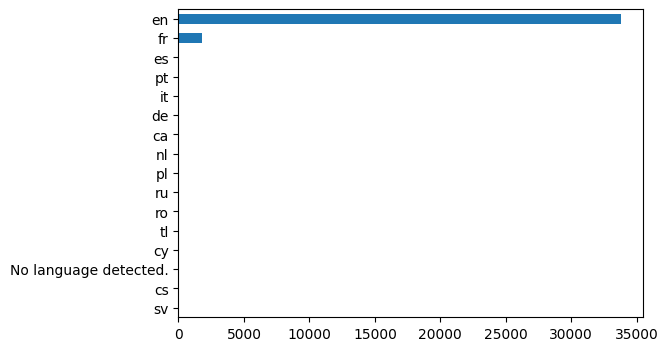

In [286]:
plt.figure(figsize=(6,4))
df3.lang.value_counts().sort_values().plot(kind = 'barh')

In [287]:
df3_eng = df3[df3.lang=='en']

In [288]:
df3_eng = df3_eng.reset_index(drop=True)

## Extract keywords

In order to extract keywords, I use the library summa, which implements the TextRank algorithm (similar to Google's PageRank) in order to extract important words from a text. 

In [289]:
def clean_text(text_data):
    tokens = tokenizer.tokenize(text_data)
    lowercased = [w.lower() for w in tokens]
    no_sw = [w for w in lowercased if (not w in stop_words_en and not w in stop_words_fr)]
    lemmas = [lemmatizer.lemmatize(word) for word in no_sw]
    no_punct = [w for w in lemmas if w.isalpha()]#if more time, avoid deleting dashes
    final = [w for w in no_punct if len(w)>2]
    return ' '.join(final)

In [290]:
df3_eng['clean_abstract']=df3_eng['abstract'].apply(clean_text)

In [291]:
df3_eng['clean_title']=df3_eng['title'].apply(clean_text)

In [292]:
df3_eng.head()

,id,title,abstract_inverted_index,abstract,lang,clean_abstract,clean_title
0,https://openalex.org/W2511949746,EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...,"{'To': [0], 'present': [1, 392], 'a': [2, 49, ...",To present a summary of the 2016 version of th...,en,present summary version european association u...,guideline prostate part screening diagnosis lo...
1,https://openalex.org/W2805354595,Atezolizumab for First-Line Treatment of Metas...,"{'The': [0, 84, 147, 183, 330], 'cancer-cell-k...",The cancer-cell-killing property of atezolizum...,en,property atezolizumab may enhanced blockade va...,atezolizumab treatment metastatic nonsquamous ...
2,https://openalex.org/W2796277309,Review on nanoparticles and nanostructured mat...,"{'Nanomaterials': [0], '(NMs)': [1], 'have': [...",Nanomaterials (NMs) have gained prominence in ...,en,nanomaterials gained prominence technological ...,review nanoparticles nanostructured material h...
3,https://openalex.org/W2969802526,A global view of hepatocellular carcinoma: tre...,"{'Hepatocellular': [0], 'carcinoma': [1], '(HC...",Hepatocellular carcinoma (HCC) is the fourth m...,en,hepatocellular carcinoma hcc fourth common cau...,global view hepatocellular carcinoma trend ris...
4,https://openalex.org/W2885896746,Clinical Practice Guidelines for the Preventio...,"{'To': [0], 'update': [1], 'and': [2, 15, 27, ...",To update and expand the 2013 Clinical Practic...,en,update expand clinical practice guideline mana...,clinical practice guideline prevention managem...


In [293]:
def extract_keywords(row):
    kwds_abs = keywords.keywords(row['clean_abstract'], scores=False).split()[0:10]
    kwds_title = keywords.keywords(row['clean_title'], scores=False).split()[0:10]
    return list(set(kwds_abs+kwds_title))

In [294]:
df3_eng['keywords'] = df3_eng.apply(extract_keywords, axis=1)

In [295]:
df3_eng.to_csv('data/extracted_keywords.csv', index=False)

In [296]:
df3_eng = pd.read_csv('data/extracted_keywords.csv')  

In [297]:
df3_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33821 entries, 0 to 33820
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       33821 non-null  object
 1   title                    33821 non-null  object
 2   abstract_inverted_index  33821 non-null  object
 3   abstract                 33821 non-null  object
 4   lang                     33821 non-null  object
 5   clean_abstract           33821 non-null  object
 6   clean_title              33801 non-null  object
 7   keywords                 33821 non-null  object
dtypes: object(8)
memory usage: 2.1+ MB


I also made a quick attempt to extract n-grams, since I realize that in a proper keyword extraction important n-grams should be extracted too. I did it with the library YAKE, but I didn't obtain satisfying results. I include an example here only for illustration. 

If I had had more time, I would have looked into other ways to extract n-grams, possibly by using the TextRank algorithm as well, but including common phrases as elements of the vocabulary..

In [302]:
import yake 

def extract_keywords_YAKE(text):
    language = "en"
    max_ngram_size = 3
    deduplication_thresold = 0.9
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = 5

    kw_extractor = yake.KeywordExtractor(lan=language, 
                                     n=max_ngram_size, 
                                     dedupLim=deduplication_thresold, 
                                     dedupFunc=deduplication_algo, 
                                     windowsSize=windowSize, 
                                     top=numOfKeywords)
                                            
    keywords = kw_extractor.extract_keywords(text)

    return keywords

In [304]:
example=df3_eng.clean_abstract[0]
example

'present summary version european association urology eau european society radiotherapy oncology estro international society geriatric oncology siog guideline screening diagnosis local treatment curative intent clinically localised prostate cancer pca working panel performed literature review new data guideline updated level evidence grade recommendation added based systematic review mutation added risk factor early aggressive addition gleason score international society urological pathology grading system systematic screening still instead individual strategy following detailed discussion taking account patient wish life expectancy must early antigen test use risk calculator one promising biomarker tool investigated might able limit overdetection insignificant breaking link diagnosis treatment may lower overtreatment multiparametric magnetic resonance imaging using standardised reporting replace systematic biopsy robustly nested within diagnostic key role local active surveillance alw

In [306]:
extract_keywords_YAKE(example)
#Even with just one example, it becomes obvious that the keywords are not very relevant.
#I would need to investigate more to see why it gives these results.
#For now, I leave this aside.

[('international society geriatric', 0.0002764127962115132),
 ('society radiotherapy oncology', 0.00031991192124899043),
 ('society geriatric oncology', 0.00031991192124899043),
 ('european society radiotherapy', 0.0003241202059164023),
 ('clinically localised prostate', 0.0003859936879586322)]

## Get most common keywords

In [308]:
flat_kwds = [item for items in [ast.literal_eval(item) for item in df3_eng.keywords.values] for item in items]
flat_kwds

['oncology',
 'treatment',
 'diagnosis',
 'local',
 'screening',
 'discussed',
 'increased',
 'guideline',
 'discussion',
 'prostate',
 'pca',
 'group',
 'patient',
 'survival',
 'bcp',
 'death',
 'abcp',
 'nonsquamous',
 'expression',
 'plus',
 'atezolizumab',
 'population',
 'technological',
 'nanomaterials',
 'prominence',
 'production',
 'growth',
 'property',
 'gained',
 'increased',
 'increase',
 'advancement',
 'nanoparticles',
 'preventable',
 'treatment',
 'medical',
 'view',
 'disease',
 'hcc',
 'prevention',
 'curative',
 'potentially',
 'liver',
 'potential',
 'outcome',
 'question',
 'patient',
 'recommendation',
 'pain',
 'developed',
 'survivor',
 'evidence',
 'disruption',
 'guideline',
 'clinical',
 'practice',
 'atrial',
 'patient',
 'noac',
 'noacs',
 'dosing',
 'antagonist',
 'oral',
 'anticoagulant',
 'anticoagulation',
 'use',
 'heart',
 'practical',
 'study',
 'prevalence',
 'global',
 'country',
 'diagnostic',
 'obstructive',
 'available',
 'data',
 'apnoea',
 '

In [309]:
common_academic_ws = 'ability, absence, account, achievement, act, action, activity, addition, adoption, adult, advance, advantage, advice, age, aim, alternative, amount, analogy, analysis, application, approach, argument, aspect, assertion, assessment, assistance, association, assumption, attempt, attention, attitude, author, awareness, balance, basis, behaviour, being, belief, benefit, bias, birth, capacity, case, category, cause, centre, challenge, change, character, characteristic, choice, circumstance, class, classification, code, colleague, combination, commitment, committee, communication, community, comparison, complexity, compromise, concentration, concept, conception, concern, conclusion, condition, conduct, conflict, consensus, consequence, consideration, constraint, construction, content, contradiction, contrast, contribution, control, convention, correlation, country, creation, crisis, criterion, criticism, culture, damage, data, debate, decision, decline, defence, definition, degree, demand, description, destruction, determination, development, difference, difficulty, dilemma, dimension, disadvantage, discovery, discrimination, discussion, distinction, diversity, division, doctrine, effect, effectiveness, element, emphasis, environment, error, essence, establishment, evaluation, event, evidence, evolution, examination, example, exception, exclusion, existence, expansion, experience, experiment, explanation, exposure, extent, extreme, fact, factor, failure, feature, female, figure, finding, force, form, formation, function, future, gain, group, growth, guidance, guideline, hypothesis, idea, identity, impact, implication, importance, improvement, increase, indication, individual, influence, information, insight, instance, institution, integration, interaction, interest, interpretation, intervention, introduction, investigation, isolation, issue, kind, knowledge, lack, learning, level, likelihood, limit, limitation, link, list, literature, logic, loss, maintenance, majority, male, manipulation, mankind, material, means, measure, medium, member, method, minority, mode, model, motivation, movement, need, network, norm, notion, number, observation, observer, occurrence, operation, opportunity, option, organisation, outcome, output, parallel, parent, part, participant, past, pattern, percentage, perception, period, person, personality, perspective, phenomenon, point, policy, population, position, possibility, potential, practice, presence, pressure, problem, procedure, process, production, programme, progress, property, proportion, proposition, protection, provision, publication, purpose, quality, question, range, rate, reader, reality, reason, reasoning, recognition, reduction, reference, relation, relationship, relevance, report, representative, reproduction, requirement, research, resistance, resolution, resource, respect, restriction, result, review, rise, risk, role, rule, sample, scale, scheme, scope, search, section, selection, sense, separation, series, service, set, sex, shift, significance, similarity, situation, skill, society, solution, source, space, spread, standard, statistics, stimulus, strategy, stress, structure, subject, success, summary, support, survey, system, target, task, team, technique, tendency, tension, term, theme, theory, tolerance, topic, tradition, transition, trend, type, uncertainty, understanding, unit, use, validity, value, variation, variety, version, view, viewpoint, volume, whole, work, world, accept, account (for), achieve, acquire, act, adapt, adopt, advance, advocate, affect, aid, aim, allocate, allow, alter, analyse, appear, apply, argue, arise, assert, assess, assign, associate, assist, assume, attain, attempt, attend, attribute, avoid, base, be, become, benefit, can, cause, characterise, choose, cite, claim, clarify, classify, coincide, combine, compare, compete, comprise, concentrate, concern, conclude, conduct, confine, conform, connect, consider, consist, constitute, construct, contain, contrast, contribute, control, convert, correspond, create, damage, deal, decline, define, demonstrate, depend, derive, describe, design, destroy, determine, develop, differ, differentiate, diminish, direct, discuss, display, distinguish, divide, dominate, effect, eliminate, emerge, emphasize, employ, enable, encounter, encourage, enhance, ensure, establish, evaluate, evolve, examine, exceed, exclude, exemplify, exist, expand, experience, explain, expose, express, extend, facilitate, fail, favour, finance, focus, follow, form, formulate, function, gain, generate, govern, highlight, identify, illustrate, imply, impose, improve, include, incorporate, increase, indicate, induce, influence, initiate, integrate, interpret, introduce, investigate, involve, isolate, label, lack, lead, limit, link, locate, maintain, may, measure, neglect, note, obtain, occur, operate, outline, overcome, participate, perceive, perform, permit, pose, possess, precede, predict, present, preserve, prevent, produce, promote, propose, prove, provide, publish, pursue, quote, receive, record, reduce, refer, reflect, regard, regulate, reinforce, reject, relate, rely, remain, remove, render, replace, report, represent, reproduce, require, resolve, respond, restrict, result, retain, reveal, seek, select, separate, should, show, solve, specify, state, stimulate, strengthen, stress, study, submit, suffer, suggest, summarise, supply, support, sustain, tackle, tend, term, transform, treat, undermine, undertake, use, vary, view, write, yield, absolute, abstract, acceptable, accessible, active, actual, acute, additional, adequate, alternative, apparent, applicable, appropriate, arbitrary, available, average, basic, central, certain, clear, common, competitive, complete, complex, comprehensive, considerable, consistent, conventional, correct, critical, crucial, dependent, detailed, different, difficult, distinct, dominant, early, effective, equal, equivalent, essential, evident, excessive, experimental, explicit, extensive, extreme, far, favourable, final, fixed, following, formal, frequent, fundamental, future, general, great, high, human, ideal, identical, immediate, important, inadequate, incomplete, independent, indirect, individual, inferior, influential, inherent, initial, interesting, internal, large, late, leading, likely, limited, local, logical, main, major, male, maximum, mental, minimal, minor, misleading, modern, mutual, natural, necessary, negative, new, normal, obvious, original, other, overall, parallel, partial, particular, passive, past, permanent, physical, positive, possible, potential, practical, present, previous, primary, prime, principal, productive, profound, progressive, prominent, psychological, radical, random, rapid, rational, real, realistic, recent, related, relative, relevant, representative, responsible, restricted, scientific, secondary, selective, separate, severe, sexual, significant, similar, simple, single, so-called, social, special, specific, stable, standard, strict, subsequent, substantial, successful, successive, sufficient, suitable, surprising, symbolic, systematic, theoretical, total, traditional, true, typical, unique, unlike, unlikely, unsuccessful, useful, valid, valuable, varied, various, visual, vital, wide, widespread, above, accordingly, accurately, adequately, also, approximately, at best, basically, clearly, closely, commonly, consequently, considerably, conversely, correctly, directly, effectively, e.g., either, equally, especially, essentially, explicitly, extremely, fairly, far, for example, for instance, frequently, fully, further, generally, greatly, hence, highly, however, increasingly, indeed, independently, indirectly, inevitably, initially, in general, in particular, largely, less, mainly, more, moreover, most, namely, necessarily, normally, notably, often, only, originally, over, partially, particularly, potentially, previously, primarily, purely, readily, recently, relatively, secondly, significantly, similarly, simply, socially, solely somewhat, specifically, strongly, subsequently, successfully, thereby, therefore, thus, traditionally, typically, ultimately, virtually, wholly, widely, according to, although, an, as, as opposed to, as to, as well as, because, because of, between, both, by, contrary to, depending on, despite, due to, during, each, even though, fewer, first, former, from, for, given that, in, in addition to, in common with, in favour of, in relation to, in response to, in terms of, in that, in the light of, including, its, itself, latter, less, little, many, most, of, or, other than, per, prior to, provided, rather than, same, second, several, since, some, subject to, such, such as, than, that, the, their, themselves, these, third, this, those, to, unlike, upon, versus, whereas, whether, whether or not, which, within'
# Comes from here: https://uclouvain.be/en/research-institutes/ilc/cecl/the-academic-keyword-list-akl.html
# if more time, refine this list

In [310]:
common_academic_ws = common_academic_ws.split(", ")

In [316]:
common_academic_ws.extend(['proposed', 'based', 'observed', 'associated', 'paper', 'studied', 'compared', 'provides'])

In [311]:
clean_kwds = [word for word in flat_kwds if word not in common_academic_ws]

In [313]:
def top_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(10)

In [314]:
print(top_frequent(clean_kwds))

[('patient', 2027), ('magnetic', 1373), ('cell', 1092), ('temperature', 1066), ('structural', 1015), ('measurement', 960), ('phase', 954), ('energy', 892), ('performance', 848), ('based', 836)]


In [ ]:
#if more time: ngrams, translate french into English for normalization, refine list, other algorithms for keyword extraction


# Task 4: identify the most studied diseases

In [347]:
df4 = final[final["medicine"]==1].reset_index(drop=True)

In [348]:
df4 = df4[['id']]

In [349]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9556 entries, 0 to 9555
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9556 non-null   object
dtypes: object(1)
memory usage: 74.8+ KB


In [350]:
other = df3_eng[['id', 'abstract']]
other.info()
#for this exercise, I also limit myself to the abstracts that are in English.
#in a proper study, I would previously translate the abstracts or else work with models that can detect diseases in French.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33821 entries, 0 to 33820
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        33821 non-null  object
 1   abstract  33821 non-null  object
dtypes: object(2)
memory usage: 528.6+ KB


In [351]:
df4 = df4.join(other.set_index('id'), on='id', how='inner')
#the dataframe is smaller than all those that belonged to the concept Medicine, because there were some empty abstracts

In [352]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6995 entries, 0 to 9555
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6995 non-null   object
 1   abstract  6995 non-null   object
dtypes: object(2)
memory usage: 163.9+ KB


In [325]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [328]:
def get_diseases(text):
    doc = nlp(text)
    pred = doc.ents
    diseases = [word.text for word in pred if word.label_=='DISEASE']
    return diseases

In [ ]:
# explain why I don't do cleaning. the model is sensitive blabla look it up

In [353]:
df4['diseases'] = df4['abstract'].apply(get_diseases)

In [354]:
df4.to_csv('data/extracted_diseases.csv', index=False)

In [355]:
df4 = pd.read_csv('data/extracted_diseases.csv')

In [356]:
df4.diseases

0       ['prostate cancer', 'aggressive disease', 'hyp...
1       ['nonsquamous non-small-cell lung cancer', 'NS...
2       ['Hepatocellular carcinoma', 'HCC', 'cancer-re...
3       ['Pain', 'Agitation', 'Delirium', 'Pain', 'Del...
4       ['atrial fibrillation', 'atrial fibrillation',...
                              ...                        
6990    ['Abstract Pseudomonas aeruginosa', 'opportuni...
6991                                                   []
6992                                  ['death', 'deaths']
6993                                                   []
6994                                                   []
Name: diseases, Length: 6995, dtype: object

In [357]:
dis = [wd for item in df4.diseases for wd in ast.literal_eval(item)]

In [358]:
not_diseases=['pain', 'death', 'deaths', 'toxicity']
#I identified some extracted diseases that seem wrong, so I remove them. 
#If I had more time, I would do a proper review of the extracted list, 
#by checking it against an existing list of diseases.

In [359]:
def normalize_diseases(text_data):
    
    tokens = tokenizer.tokenize(text_data)
    lowercased = [w.lower() for w in tokens]
    only_dis = [w for w in lowercased if w not in not_diseases]
    lemmas = [lemmatizer.lemmatize(w) for w in only_dis]
    
    return ' '.join(lemmas)

In [360]:
clean_dis = [item for item in [normalize_diseases(item) for item in dis] if item!='']

In [361]:
print(top_frequent(clean_dis))

[('tumor', 963), ('cancer', 867), ('osa', 571), ('infection', 539), ('asthma', 444), ('copd', 313), ('trauma', 271), ('pd', 255), ('diabetes', 254), ('stroke', 252)]


In [362]:
def least_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common()[-10:-1]

In [363]:
print(least_frequent(clean_dis))

[('• depression', 1), ('cerebral or pulmonary oedema', 1), ('telomeropathy', 1), ('anal sphincter injury', 1), ('idiopathic infertility', 1), ('undernutrition', 1), ('airway inflammatory disease', 1), ('cit deficiency', 1), ('sluggishness', 1)]


In [365]:
# Here I see a special symbol I should have cleaned previously. If I had more time I would go back and add some preprocessing function for this task.
#falta

# Task 5 (optional): clustering texts / topic modelling

# Task 6 (optional): remove duplicate entries

# Task 7: Open question

In [ ]:
open_access: to see if it is correlated with higeher collaboration
n_grams: to access text of work